In [8]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline
from torchvision import transforms
from torchvision.utils import save_image
import torch.optim as optim

In [9]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 64
block = 3 

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

torch.manual_seed(43)


trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_dl = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                            shuffle=True, num_workers=8,
                                            prefetch_factor = 2, 
                                            pin_memory = True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_dl = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             shuffle=False, num_workers=8,
                                             prefetch_factor = 2, 
                                            pin_memory = True)

val_dl = test_dl
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [10]:
is_cuda=torch.cuda.is_available()
device=torch.device("cuda" if is_cuda else "cpu")
print(device)

cuda


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


images.shape: torch.Size([64, 3, 32, 32])


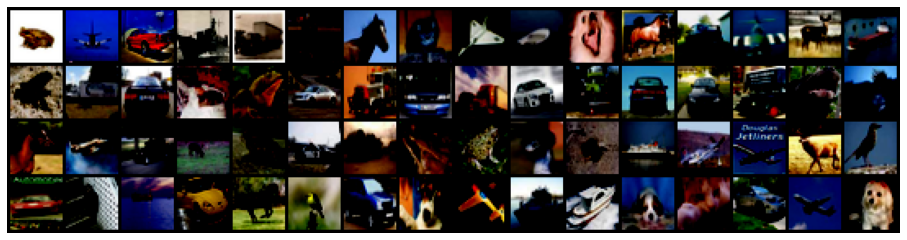

In [11]:
for images, _ in train_dl:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


images.shape: torch.Size([64, 3, 32, 32])


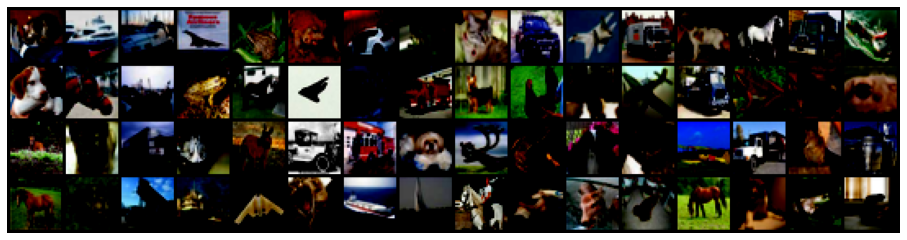

In [12]:
for images, _ in test_dl:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [13]:
class VGG(nn.Module):
    def __init__(self):
        super().__init__()

        # Set first filter  
        self.conv1_1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        
        # He initialization: 
        nn.init.kaiming_uniform_(self.conv1_1.weight, mode='fan_in', nonlinearity='relu')
        
        self.conv1_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        nn.init.kaiming_uniform_(self.conv1_2.weight, mode='fan_in', nonlinearity='relu')

        # Set second filter 
        self.conv2_1 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        nn.init.kaiming_uniform_(self.conv2_1.weight, mode='fan_in', nonlinearity='relu')
        
        self.conv2_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        nn.init.kaiming_uniform_(self.conv2_2.weight, mode='fan_in', nonlinearity='relu')
        
        # Set third filter
        self.conv3_1 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        nn.init.kaiming_uniform_(self.conv3_1.weight, mode='fan_in', nonlinearity='relu')
        
        self.conv3_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        nn.init.kaiming_uniform_(self.conv3_2.weight, mode='fan_in', nonlinearity='relu')

        #nn.init.kaiming_uniform_(self.conv3_1.weight, mode='fan_in', nonlinearity='relu')
        
        self.pool = nn.MaxPool2d(2, 2)
        
        if block is 1:
          self.fc1 = nn.Linear(8192, 120)
          self.fc2 = nn.Linear(120, 10) # CHANGE 
          self.fc3 = nn.Linear(84, 10)
        else:  
          self.fc1 = nn.Linear(2048, 400)
          self.fc2 = nn.Linear(400, 120) # CHANGE 
          self.fc3 = nn.Linear(120, 10)

    def forward(self, x):
        if block is 1:  
          # 1 VGG block: 
          x = self.pool(F.relu(self.conv1_2(F.relu(self.conv1_1(x)))))
          x = torch.flatten(x, 1)
          x = F.relu(self.fc1(x))
          x = self.fc2(x)
        else:
          # 3 VGG block 
          x = self.pool(F.relu(self.conv1_2(F.relu(self.conv1_1(x)))))
          x = self.pool(F.relu(self.conv2_2(F.relu(self.conv2_1(x)))))
          x = self.pool(F.relu(self.conv3_2(F.relu(self.conv3_1(x)))))
          x = torch.flatten(x, 1)
          x = F.relu(self.fc1(x))
          x = self.fc2(x)

        #x = self.pool(F.relu(self.conv1_2(self.conv1_1(x))))
        #x = self.pool(F.relu(self.conv2_2(self.conv2_1(x))))

        #x = torch.flatten(x, 1) # flatten all dimensions except batch
        #x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        #x = self.fc3(x)
        return x


model = VGG() #to compile the model
model = model.to(device=device) #to send the model for training on either cuda or cpu
## Loss and optimizer
learning_rate = 0.001 #I picked this because it seems to be the most used by experts
load_model = True
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr= learning_rate,momentum=0.9) #Adam seems to be the most popular for deep learning
#optimizer = optim.Adam(model.parameters(), lr = learning_rate)

## Gridsearch - Learning rate

Does not work!!! 

In [ ]:
# This one does not work, eventhough I would love it to
from skorch import NeuralNetRegressor
net = NeuralNetRegressor(VGG
                         , max_epochs=80
                         , lr=0.001
                         , verbose=1)

skorch_classifier = NeuralNetRegressor(module=VGG, optimizer=optim.SGD, verbose=0)
params = {
    "lr": [0.0001, 0.001, 0.01, 0.1],
    "max_epochs": [80]
}

X_test, Y_test = next(iter(test_dl))
grid = GridSearchCV(skorch_classifier, params)
Y_test = Y_test.reshape(-1, 1)
grid.fit(X_test, Y_test)

print("Best Score  : {}".format(grid.best_score_))
print("Best Params : {}".format(grid.best_params_))


In [14]:
lr_vec = [0.0001, 0.001, 0.005, 0.01]

epoches=20
loss_store=np.zeros((len(lr_vec), epoches))
acc_lr = np.zeros((len(lr_vec),1))

for ind_lr, lr in enumerate(lr_vec):
    model = VGG() #to compile the model
    model = model.to(device=device) #to send the model for training on either cuda or cpu
    optimizer = optim.SGD(model.parameters(), lr=lr,momentum=0.9)
    for epoch in range(epoches): 
        loss_ep = 0
        for _, (data, targets) in enumerate(train_dl):
            data = data.to(device=device)
            targets = targets.to(device=device)
            ## Forward Pass
            optimizer.zero_grad()
            score = model(data)
            loss = criterion(score,targets)
            loss.backward()
            optimizer.step()
            loss_ep += loss.item()
        print(f"Loss in epoch {epoch}: {loss_ep/len(train_dl):.3f}")
        loss_store[ind_lr, epoch] = loss_ep/len(train_dl) 
    
    with torch.no_grad():
        for data in test_dl:
            images, labels = data
            # calculate outputs by running images through the network 
            outputs = model(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            acc_lr[ind_lr] = float(correct) / float(total) * 100



Loss in epoch 0: 2.300
Loss in epoch 1: 1.865
Loss in epoch 2: 1.727
Loss in epoch 3: 1.608
Loss in epoch 4: 1.536
Loss in epoch 5: 1.481
Loss in epoch 6: 1.434
Loss in epoch 7: 1.394
Loss in epoch 8: 1.357
Loss in epoch 9: 1.327
Loss in epoch 10: 1.292
Loss in epoch 11: 1.260
Loss in epoch 12: 1.229
Loss in epoch 13: 1.203
Loss in epoch 14: 1.172
Loss in epoch 15: 1.147
Loss in epoch 16: 1.123
Loss in epoch 17: 1.094
Loss in epoch 18: 1.073
Loss in epoch 19: 1.053


RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [ ]:
xaxis=np.arange(0,epoches)
xi = list(range(len(xaxis)))
plt.figure(1) 
plt.plot(xaxis, loss_store[0,:], label = "lr = 0.0001")
plt.plot(xaxis, loss_store[1,:], label = "lr = 0.001")
plt.plot(xaxis, loss_store[2,:], label = "lr = 0.005")
plt.plot(xaxis, loss_store[3,:], label = "lr = 0.01")
plt.legend() 
plt.xlabel("Epoch") 
plt.ylabel("Loss")
plt.show()


In [ ]:
loss_store=[]
acc_store=[]
epoches=100
xaxis=np.arange(0,epoches)

for epoch in range(epoches): #I decided to train the model for 50 epochs
    loss_ep = 0
    
    for _, (data, targets) in enumerate(train_dl):
        data = data.to(device=device)
        targets = targets.to(device=device)
        ## Forward Pass
        optimizer.zero_grad()
        score = model(data)
        loss = criterion(score,targets)
        loss.backward()
        optimizer.step()
        loss_ep += loss.item()
    print(f"Loss in epoch {epoch}: {loss_ep/len(train_dl):.3f}")
    loss_store.append(loss_ep/len(train_dl))
    

    with torch.no_grad():
        num_correct = 0
        num_samples = 0
        for _, (data,targets) in enumerate(val_dl):
            data = data.to(device=device)
            targets = targets.to(device=device)
            ## Forward Pass
            score = model(data)
            _, predictions = score.max(1)
            num_correct += (predictions == targets).sum()
            num_samples += predictions.size(0)
        print(
            f"Got {num_correct} / {num_samples} with accuracy {float(num_correct) / float(num_samples) * 100:.2f}"
        )
        acc_store.append(float(num_correct) / float(num_samples) * 100)

In [ ]:
plt.figure(1)
plt.plot(loss_store,marker='*')
plt.figure(2)
plt.plot(acc_store,marker='.')

In [ ]:
PATH = './cifar_net_adam.pth'
torch.save(model.state_dict(), PATH)

In [ ]:
dataiter = iter(test_dl)
images, labels = dataiter.next()

# print images
plt.imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [ ]:
net = VGG()
net.load_state_dict(torch.load(PATH))

outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_dl:
        images, labels = data
        # calculate outputs by running images through the network 
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(
        f"Accuracy of the network on the 10000 test images: {float(correct) / float(total) * 100:.2f}%"
)